In [1]:
import pandas as pd
import pickle
from mpl_finance import candlestick2_ohlc
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
import datetime as dt


import seaborn as sns

/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
with open('../data/benchmark_data.pkl', 'rb') as handle:
    bm = pickle.load(handle)
ibex = bm['ibex']

db_dataset = pd.read_csv("../data/doble_suelo_balanceado.csv")
db_dataset["date"] = pd.to_datetime(db_dataset["date"], format="%Y-%m-%d").to_frame()

window = 30

In [3]:
def etiquetado_datos(window_df: pd.DataFrame):
    lows = window_df.iloc[argrelextrema(window_df.low.values, np.less_equal, order=n_min)[0]]["low"]
    lmax = windata.iloc[argrelextrema(windata.low.values, np.greater_equal, order=n_max)[0]]["low"]

    hmax = windata.iloc[argrelextrema(windata.high.values, np.greater_equal, order=n_max)[0]]["high"]

    # Si ocurren antes el minimo o el maximo
    is_min_before_max = int(
        window_df.iloc[np.argmin(window_df["low"])].name < window_df.iloc[np.argmax(window_df["low"])].name)

    # distancia entre los dos minimos en días
    local_min = lows.to_frame().sort_values(by="low")[:2]

    if len(local_min) == 2:
        dias_entre_minimos = abs((local_min.iloc[0].name - local_min.iloc[1].name).days)
    else:
        dias_entre_minimos = -1

    # distancia entre los dos minimos en precio
    if len(local_min) == 2:
        distancia_precio_minimos = round(abs(local_min.iloc[0].low - local_min.iloc[1].low), 2)
    else:
        distancia_precio_minimos = -1

    # retorno de la ventana
    retorno = round(np.sum(np.log(windata["close"]).diff()), 4)

    # distancia de la primera vela al primer minimo
    if len(local_min) == 2:
        dt_ordered_local_min = local_min.sort_index()
        primer_dia_ventana = windata.iloc[0].name
        dia_primer_minimo = dt_ordered_local_min.iloc[0].name
        distancia_primer_dia_minimo_local = abs((primer_dia_ventana - dia_primer_minimo).days)
        if distancia_primer_dia_minimo_local == 0:
            distancia_primer_dia_minimo_local = -1
    else:
        distancia_primer_dia_minimo_local = -1

    # numero de maximos locales entre dos minimos
    if len(local_min) == 2:
        dt_ordered_local_min = local_min.sort_index()
        l_max = (lmax.to_frame().index > dt_ordered_local_min.iloc[0].name) * (
                lmax.to_frame().index < dt_ordered_local_min.iloc[1].name)
        n_local_max = len(lmax[l_max])
    else:
        n_local_max = -1

    # diferencia entre el cierre del maximo local entre dos minimos y el maximo después del segundo minimo local
    if len(local_min) == 2:
        dt_ordered_local_min = local_min.sort_index()
        l_max = (lmax.to_frame().index > dt_ordered_local_min.iloc[0].name) * (
                lmax.to_frame().index < dt_ordered_local_min.iloc[1].name)
        precio_maximo_local = lmax[l_max].max()
        precio_maximo_final = windata[dt_ordered_local_min.iloc[1].name:].close.max()
        diferencia_precio = round(precio_maximo_final - precio_maximo_local, 4)
        if not diferencia_precio: diferencia_precio = 0
    else:
        diferencia_precio = 0

    # diferencia en dias entre los dos máximos locales de la ventana
    local_max = hmax.to_frame().sort_values(by="high", ascending=False)[:2]
    if len(local_max) == 2:
        dias_entre_maximos = abs((local_max.iloc[0].name - local_max.iloc[1].name).days)
    else:
        dias_entre_maximos = -1

    # distancia de la primera vela al primer máximo
    if len(local_max) == 2:
        dt_ordered_local_max = local_max.sort_index()
        primer_dia_ventana = windata.iloc[0].name
        dia_primer_maximo = dt_ordered_local_max.iloc[0].name
        distancia_primer_dia_maximo_local = abs((primer_dia_ventana - dia_primer_maximo).days)
        if distancia_primer_dia_maximo_local == 0:
            distancia_primer_dia_maximo_local = -1
    else:
        distancia_primer_dia_maximo_local = -1

    # distancia entre los dos maximos en precio
    if len(local_max) == 2:
        distancia_precio_maximos = round(abs(local_max.iloc[0].high - local_max.iloc[1].high), 2)
    else:
        distancia_precio_maximos = -1

    return (is_min_before_max,
            dias_entre_minimos,
            distancia_precio_minimos,
            retorno,
            distancia_primer_dia_minimo_local,
            n_local_max,
            diferencia_precio,
            dias_entre_maximos,
            distancia_primer_dia_maximo_local,
            distancia_precio_maximos)



In [4]:
datos_etiquetados = pd.DataFrame(
    columns=["is_min_before_max", "dias_entre_minimos", "distancia_precio_minimos", "retorno",
             "distancia_primer_dia_minimo_local", "n_local_max", "diferencia_precio", "dias_entre_maximos",
             "distancia_primer_dia_maximo_local", "distancia_precio_maximos", "class"])

n_min = 4
n_max = 1

for data in db_dataset.iterrows():
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

    windata = ibex.loc[data[1].date:].head(window)

    is_min_before_max, dias_entre_minimos, distancia_precio_minimos, retorno, distancia_primer_dia_minimo_local, n_local_max, diferencia_precio, dias_entre_maximos, distancia_primer_dia_maximo_local, distancia_precio_maximos = etiquetado_datos(
        windata.copy())

    lows = windata.iloc[argrelextrema(windata.low.values, np.less_equal, order=n_min)[0]]["low"]
    lmax = windata.iloc[argrelextrema(windata.low.values, np.greater_equal, order=n_max)[0]]["low"]

    local_min = lows.to_frame().sort_values(by="low")[:2]
    local_max = lmax.to_frame().sort_values(by="low", ascending=False)[:2]
    local_max = lmax.to_frame()

    labeled_obs = {
        "is_min_before_max": is_min_before_max,
        "dias_entre_minimos": dias_entre_minimos,
        "distancia_precio_minimos": distancia_precio_minimos,
        "retorno": retorno,
        "distancia_primer_dia_minimo_local": distancia_primer_dia_minimo_local,
        "n_local_max": n_local_max,
        "diferencia_precio": diferencia_precio,
        "dias_entre_maximos": dias_entre_maximos,
        "distancia_primer_dia_maximo_local": distancia_primer_dia_maximo_local,
        "distancia_precio_maximos": distancia_precio_maximos,
        "class": data[1]["class"]
    }

    datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)

/tmp/ipykernel_1572444/2299910078.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_1572444/2299910078.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_1572444/2299910078.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_1572444/2299910078.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_

In [5]:
features = datos_etiquetados.loc[:, datos_etiquetados.columns != "class" ]
target = datos_etiquetados["class"]

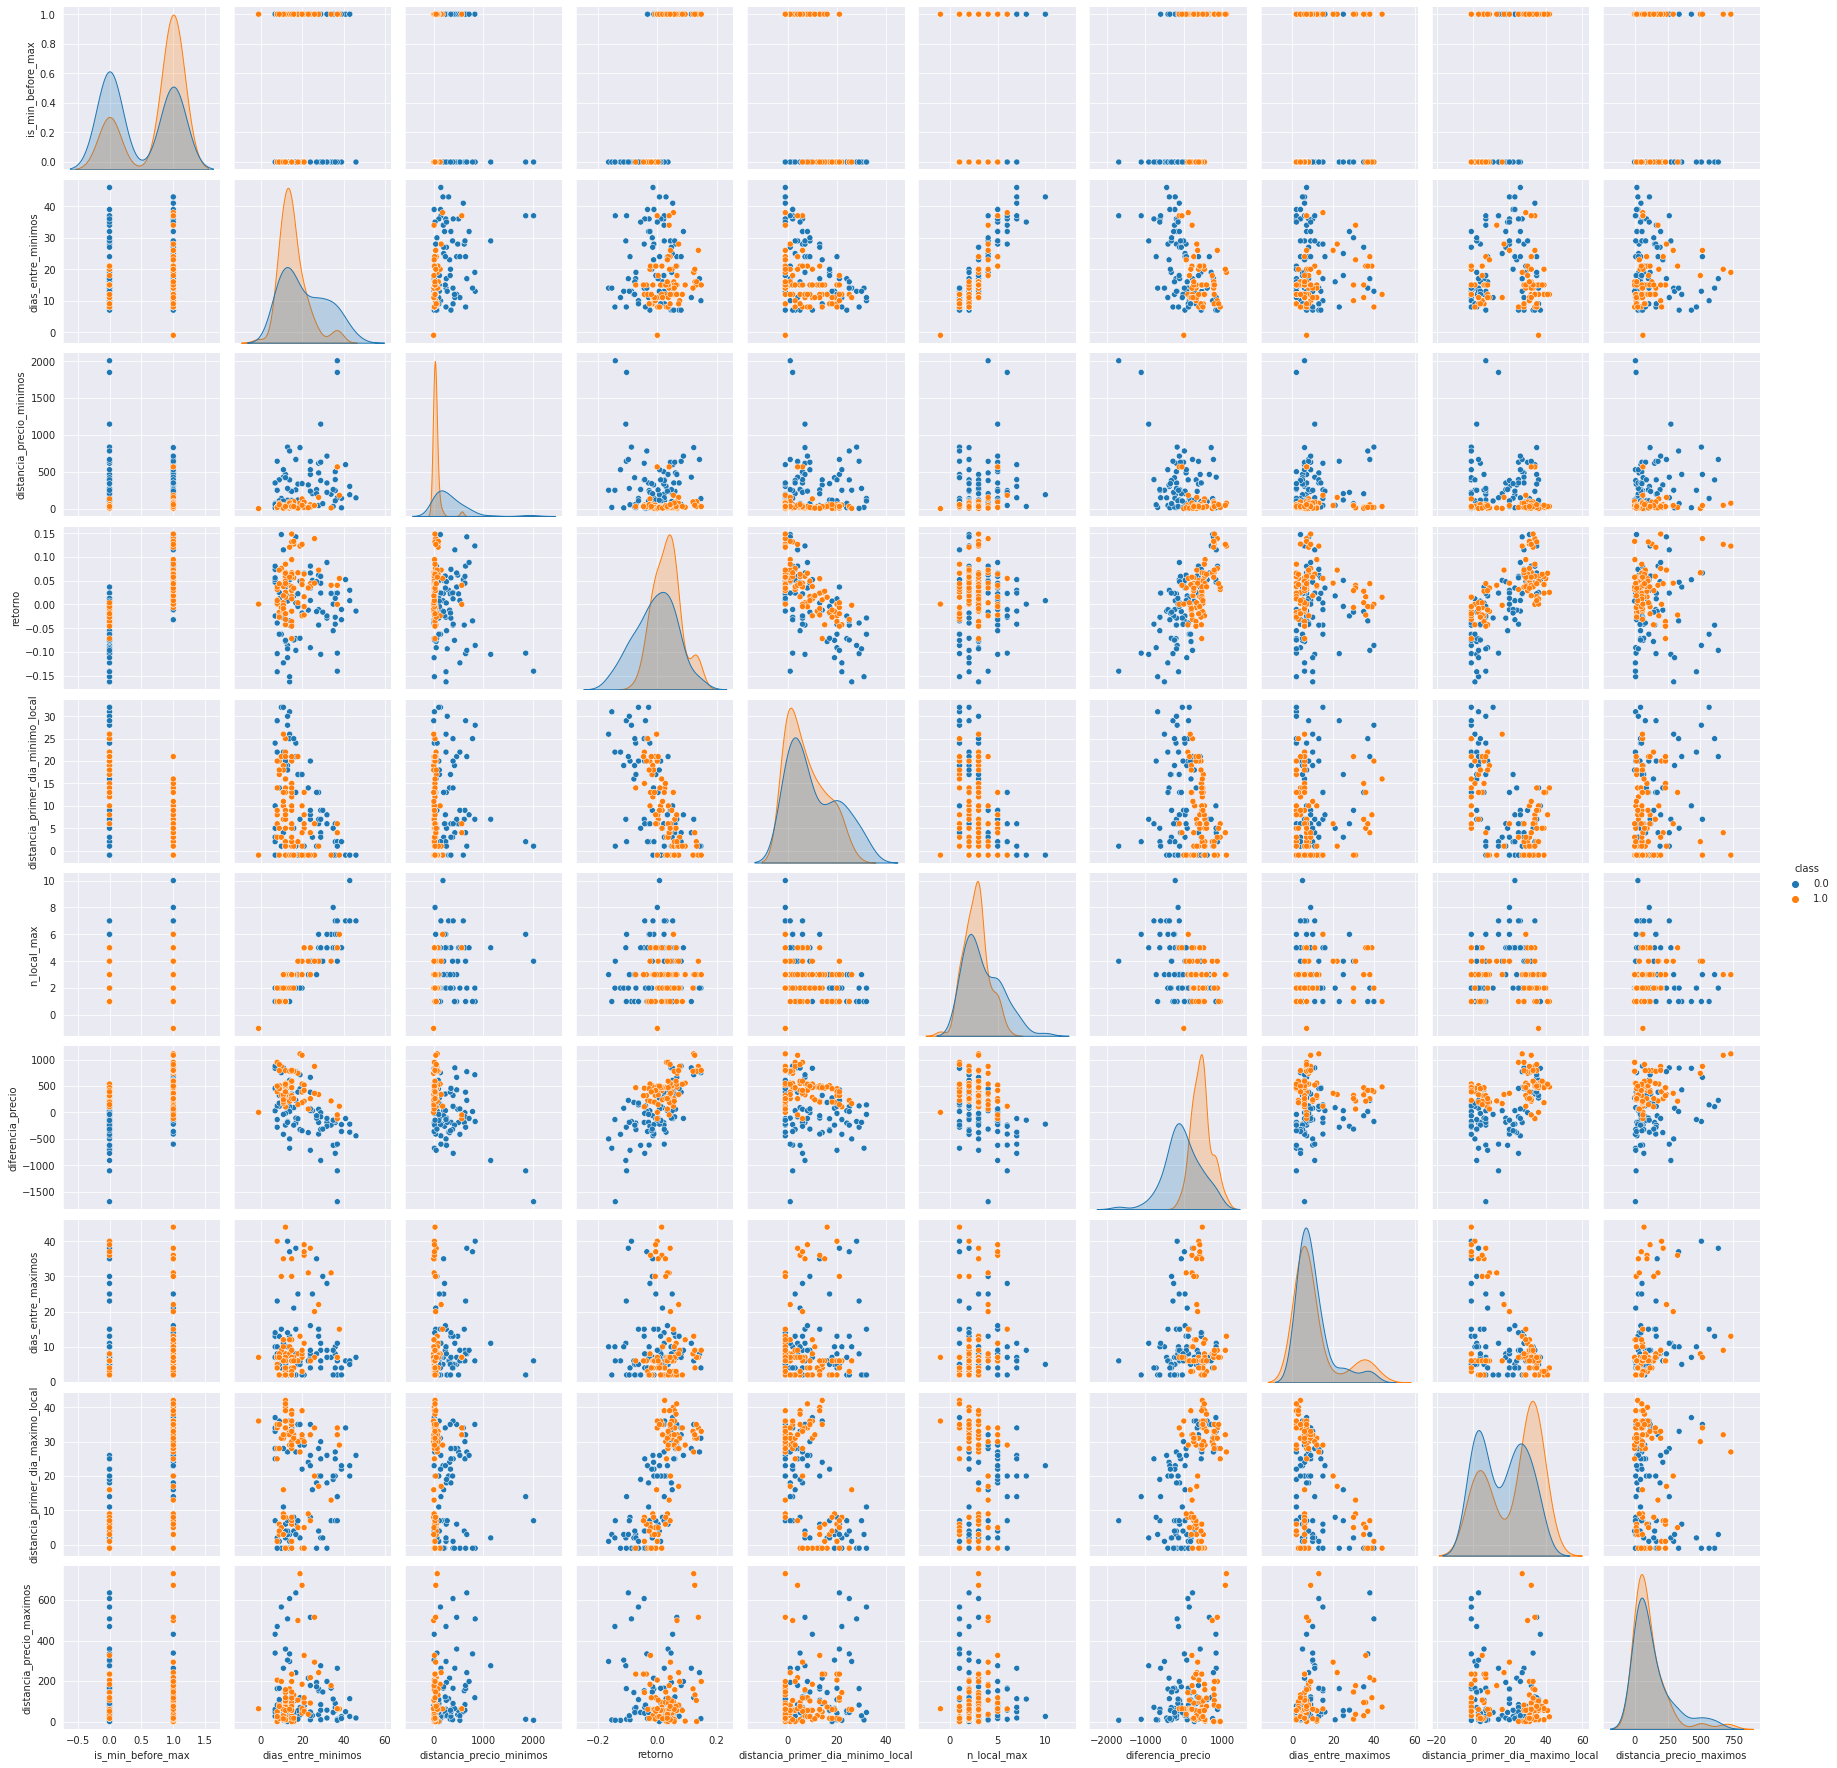

In [6]:
sns.pairplot(datos_etiquetados, hue='class', diag_kind='kde')

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

In [8]:

ft_norm_arr = MinMaxScaler().fit_transform(features)
ft_norm = pd.DataFrame(ft_norm_arr, columns=features.columns)

In [9]:
train_x, test_x, train_y, test_y = train_test_split(ft_norm.values,
                                                    target.values,
                                                    test_size=0.8,
                                                    stratify=target.values,
                                                    random_state=11
                                                    )

In [10]:
tree_it0 = DecisionTreeClassifier(max_depth=5)

In [11]:
tree_it0.fit(train_x, train_y)
y_pred_single = tree_it0.predict(test_x)

In [12]:
print("Tree:", accuracy_score(test_y, y_pred_single))

Tree: 0.8947368421052632


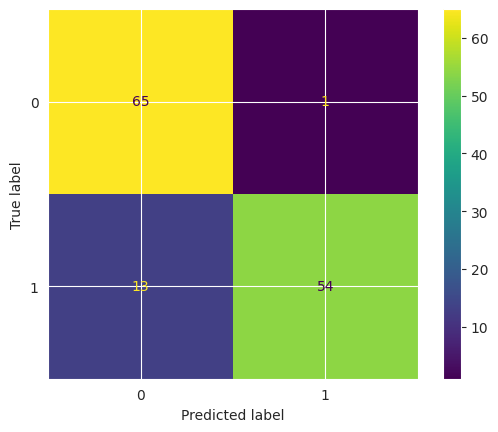

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_multi = confusion_matrix(test_y, y_pred_single)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi, display_labels=[0, 1])
disp.plot()
plt.show()

In [14]:
from sklearn.metrics import classification_report
print(classification_report(test_y, y_pred_single, target_names=["Sin patron", "Doble suelo"]))

              precision    recall  f1-score   support

  Sin patron       0.83      0.98      0.90        66
 Doble suelo       0.98      0.81      0.89        67

    accuracy                           0.89       133
   macro avg       0.91      0.90      0.89       133
weighted avg       0.91      0.89      0.89       133



Curva ROC

In [15]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

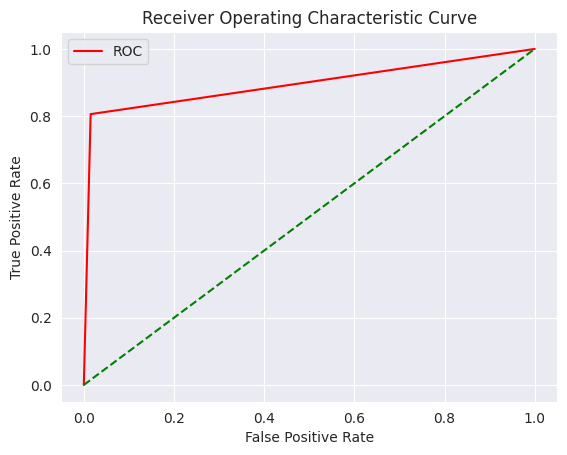

In [16]:
fper, tper, thresholds = roc_curve(test_y, y_pred_single)
plot_roc_curve(fper, tper)

In [17]:
from sklearn import metrics
metrics.auc(fper, tper)

0.8954093170511082

#### Importancia de las caracterı́sticas generadas, utilizando la importancia por permutación.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'distancia_precio_minimos'),
  Text(1, 0, 'diferencia_precio'),
  Text(2, 0, 'dias_entre_minimos'),
  Text(3, 0, 'retorno'),
  Text(4, 0, 'is_min_before_max'),
  Text(5, 0, 'distancia_primer_dia_minimo_local'),
  Text(6, 0, 'n_local_max'),
  Text(7, 0, 'dias_entre_maximos'),
  Text(8, 0, 'distancia_primer_dia_maximo_local'),
  Text(9, 0, 'distancia_precio_maximos')])

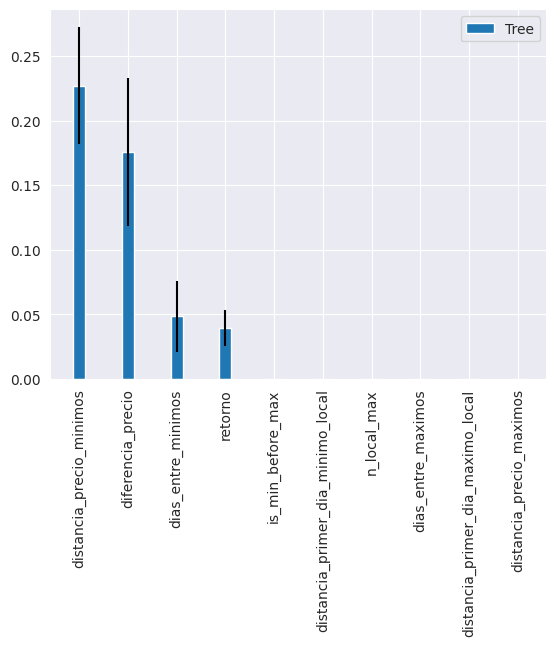

In [18]:
pimp_tree = permutation_importance(tree_it0, train_x, train_y, n_repeats=10)

imp_df = pd.DataFrame({'ft': ft_norm.columns,
                       'tree_mean': pimp_tree.importances_mean,
                       'tree_std': pimp_tree.importances_std,
                       })
imp_df.sort_values('tree_mean', ascending=False, inplace=True)

bw = 0.25
plt.bar(np.arange(imp_df.shape[0]),
        imp_df.tree_mean,
        yerr=imp_df.tree_std,
        width=bw,
        tick_label=imp_df.ft,
        )
plt.legend(['Tree'])
plt.xticks(rotation=90)

#### Iteración 2

In [19]:
datos_etiquetados = pd.DataFrame(
    columns=["is_min_before_max", "dias_entre_minimos", "distancia_precio_minimos", "retorno",
             "distancia_primer_dia_minimo_local", "n_local_max", "diferencia_precio", "dias_entre_maximos",
             "distancia_primer_dia_maximo_local", "distancia_precio_maximos", "class"])

In [20]:
patron_ds = pd.read_csv("../data/doble_suelo_balanceado.csv")
patron_dt = pd.read_csv("../data/ejemplos_doble_techo_final.csv")
sin_patron = patron_dt[patron_dt["class"] == 0]
doble_suelo = patron_ds[patron_ds["class"] == 1]
doble_techo = patron_dt[patron_dt["class"] == 1]
doble_techo["class"] = 2

patrones = pd.concat([sin_patron, doble_suelo, doble_techo], ignore_index=True)
patrones = patrones.iloc[:, 1:]

/tmp/ipykernel_1572444/201585058.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doble_techo["class"] = 2


In [21]:
n_min = 4
n_max = 1

for data in patrones.iterrows():
    windata = ibex.loc[data[1].date:].head(window)

    is_min_before_max, dias_entre_minimos, distancia_precio_minimos, retorno, distancia_primer_dia_minimo_local, n_local_max, diferencia_precio, dias_entre_maximos, distancia_primer_dia_maximo_local, distancia_precio_maximos = etiquetado_datos(windata.copy())

    lows = windata.iloc[argrelextrema(windata.low.values, np.less_equal, order=n_min)[0]]["low"]
    lmax = windata.iloc[argrelextrema(windata.low.values, np.greater_equal, order=n_max)[0]]["low"]

    local_min = lows.to_frame().sort_values(by="low")[:2]
    local_max = lmax.to_frame().sort_values(by="low", ascending=False)[:2]
    local_max = lmax.to_frame()

    labeled_obs = {
        "is_min_before_max": is_min_before_max,
        "dias_entre_minimos": dias_entre_minimos,
        "distancia_precio_minimos": distancia_precio_minimos,
        "retorno": retorno,
        "distancia_primer_dia_minimo_local": distancia_primer_dia_minimo_local,
        "n_local_max": n_local_max,
        "diferencia_precio": diferencia_precio,
        "dias_entre_maximos": dias_entre_maximos,
        "distancia_primer_dia_maximo_local": distancia_primer_dia_maximo_local,
        "distancia_precio_maximos": distancia_precio_maximos,
        "class": data[1]["class"]
    }

    datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)



/tmp/ipykernel_1572444/1768053144.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_1572444/1768053144.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_1572444/1768053144.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_1572444/1768053144.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_

In [22]:
features = datos_etiquetados.loc[:, datos_etiquetados.columns != "class" ]
target = datos_etiquetados["class"]

ft_norm_arr = MinMaxScaler().fit_transform(features)
ft_norm = pd.DataFrame(ft_norm_arr, columns=features.columns)

train_x, test_x, train_y, test_y = train_test_split(ft_norm.values,
                                                    target.values,
                                                    test_size=0.8,
                                                    stratify=target.values,
                                                    random_state=11
                                                    )

#### Entrenamiento de modelos

In [23]:
tree = DecisionTreeClassifier(random_state=112)
knn = KNeighborsClassifier()
forest = RandomForestClassifier(random_state=121)

scores_tree = cross_val_score(tree, train_x, train_y, cv=5)
scores_knn = cross_val_score(knn, train_x, train_y, cv=5)
scores_forest = cross_val_score(forest, train_x, train_y, cv=5)

In [24]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_tree.mean(), scores_tree.std()))
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_knn.mean(), scores_knn.std()))
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_forest.mean(), scores_forest.std()))

0.53 accuracy with a standard deviation of 0.16
0.53 accuracy with a standard deviation of 0.17
0.61 accuracy with a standard deviation of 0.08


In [25]:
forest.fit(train_x, train_y)

y_pred_rf = forest.predict(test_x)

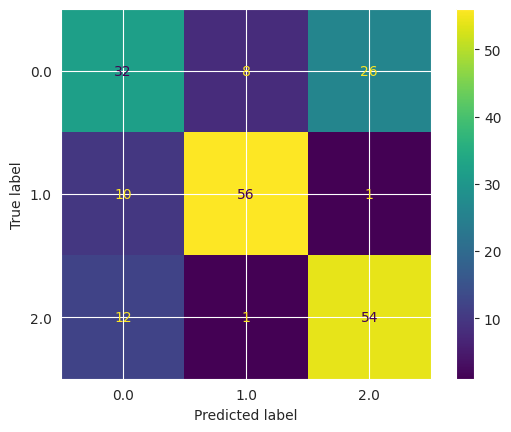

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_multi = confusion_matrix(test_y, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi, display_labels=forest.classes_)
disp.plot()
plt.show()

#### Precission & Recall

In [27]:
print(classification_report(test_y, y_pred_rf, target_names=["Sin patron", "Doble suelo", "Doble techo"]))

              precision    recall  f1-score   support

  Sin patron       0.59      0.48      0.53        66
 Doble suelo       0.86      0.84      0.85        67
 Doble techo       0.67      0.81      0.73        67

    accuracy                           0.71       200
   macro avg       0.71      0.71      0.70       200
weighted avg       0.71      0.71      0.70       200



#### Identificación de patrones en EuroStoxx

In [28]:
stoxx = pd.read_csv("../data/eurostoxx.csv")
stoxx.columns = ["date", "open", "high", "low", "close"]
stoxx["date"] = stoxx["date"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())
stoxx.set_index("date", inplace=True)

datos_etiquetados = pd.DataFrame( columns=["is_min_before_max", "dias_entre_minimos", "distancia_precio_minimos", "retorno",
             "distancia_primer_dia_minimo_local", "n_local_max", "diferencia_precio", "dias_entre_maximos",
             "distancia_primer_dia_maximo_local", "distancia_precio_maximos"])

In [29]:
for data in stoxx.iterrows():
    windata = stoxx.loc[data[1].name:].head(30)


    is_min_before_max, dias_entre_minimos, distancia_precio_minimos, retorno, distancia_primer_dia_minimo_local, n_local_max, diferencia_precio, dias_entre_maximos, distancia_primer_dia_maximo_local, distancia_precio_maximos = etiquetado_datos(windata.copy())

    labeled_obs = {
        "is_min_before_max": is_min_before_max,
        "dias_entre_minimos": dias_entre_minimos,
        "distancia_precio_minimos": distancia_precio_minimos,
        "retorno": retorno,
        "distancia_primer_dia_minimo_local": distancia_primer_dia_minimo_local,
        "n_local_max": n_local_max,
        "diferencia_precio": diferencia_precio,
        "dias_entre_maximos": dias_entre_maximos,
        "distancia_primer_dia_maximo_local": distancia_primer_dia_maximo_local,
        "distancia_precio_maximos": distancia_precio_maximos,
    }

    datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)

/tmp/ipykernel_1572444/1109857009.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_1572444/1109857009.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_1572444/1109857009.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_1572444/1109857009.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_

In [30]:
ft_norm_arr = MinMaxScaler().fit_transform(datos_etiquetados)
ft_norm = pd.DataFrame(ft_norm_arr, columns=datos_etiquetados.columns)

In [31]:
predict_prob = forest.predict_proba(ft_norm)
predict_prob = pd.DataFrame(predict_prob)
predict_prob.columns = ["class_0", "class_1", "class_2"]

/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


#### 5 Ejemplos de doble techo

In [32]:
dt = predict_prob["class_2"].sort_values(ascending=False)
ds = predict_prob["class_1"].sort_values(ascending=False)
sp = predict_prob["class_0"].sort_values(ascending=False)


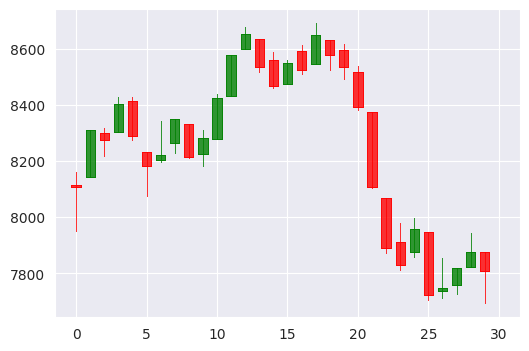

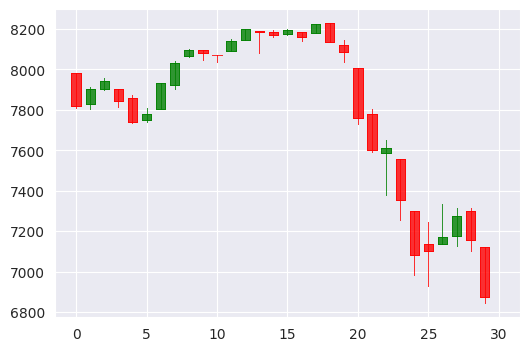

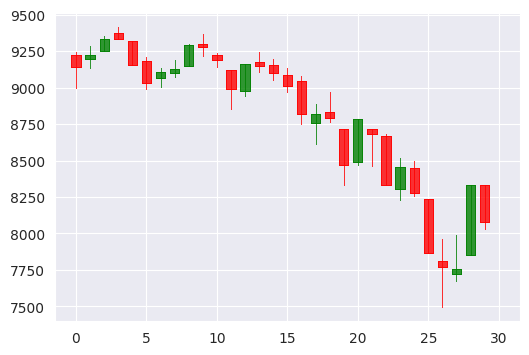

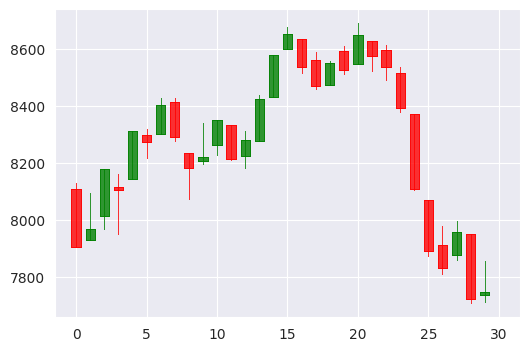

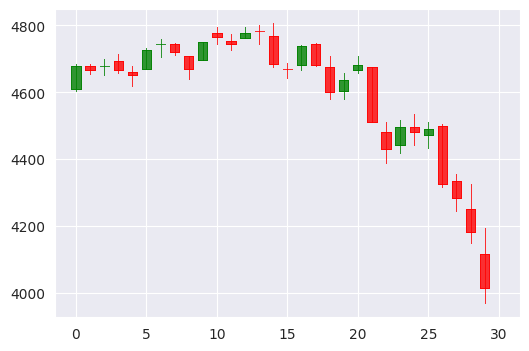

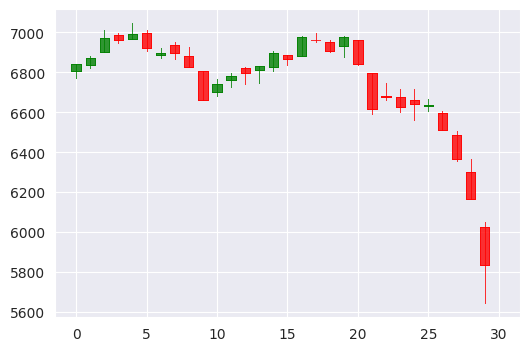

In [33]:
for idx in dt.index[3:9]:
    window = stoxx.iloc[idx:idx+30]
    fig, ax = plt.subplots(figsize=(6, 4))
    candlestick2_ohlc(ax, window.open, window.high,
                      window.low, window.close,
                      colorup='g', colordown='r', width=0.66, alpha=0.8)
    plt.show()

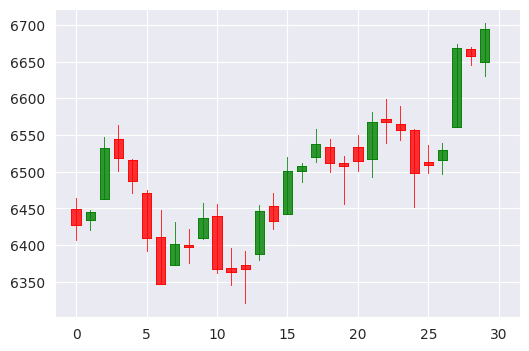

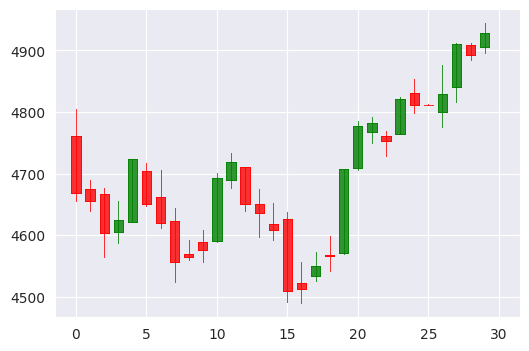

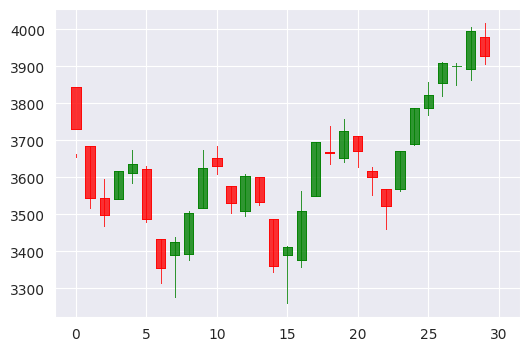

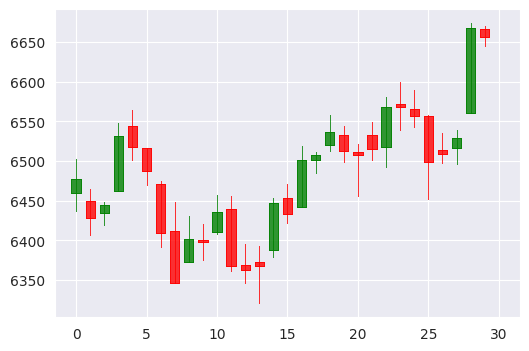

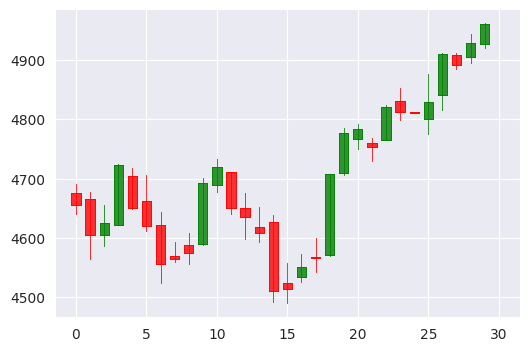

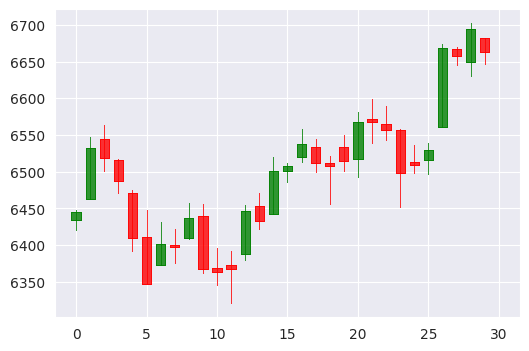

In [34]:
for idx in ds.index[3:9]:
    window = stoxx.iloc[idx:idx+30]
    fig, ax = plt.subplots(figsize=(6, 4))
    candlestick2_ohlc(ax, window.open, window.high,
                      window.low, window.close,
                      colorup='g', colordown='r', width=0.66, alpha=0.8)
    plt.show()

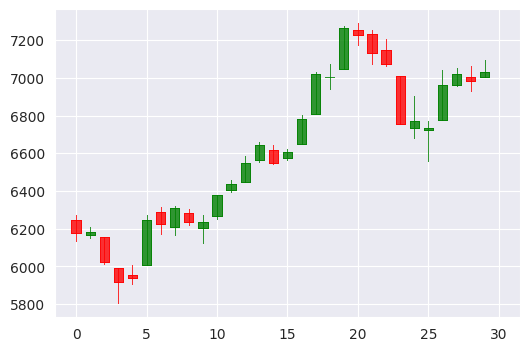

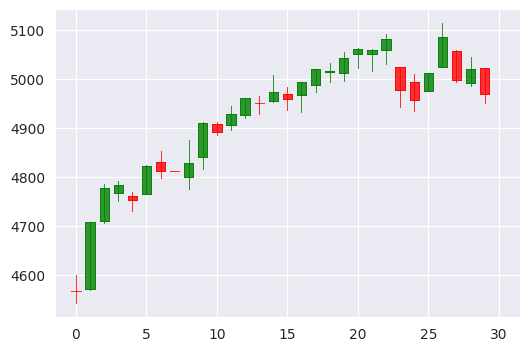

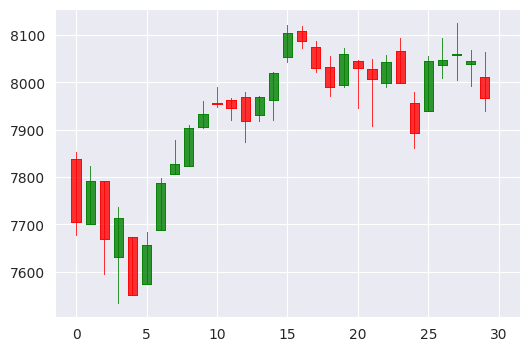

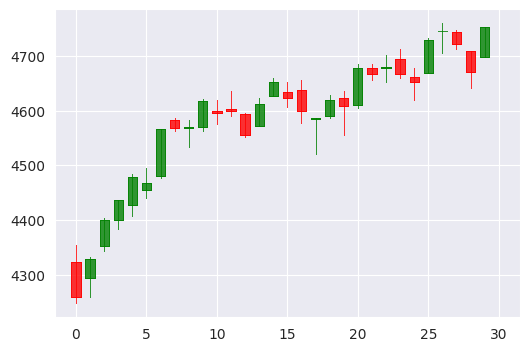

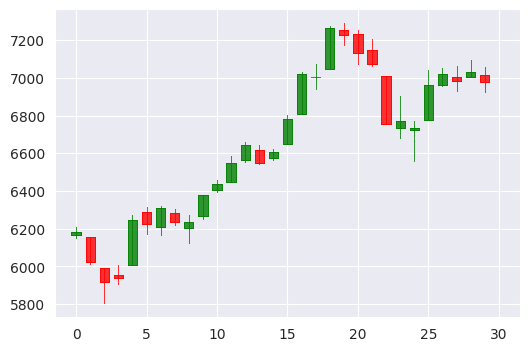

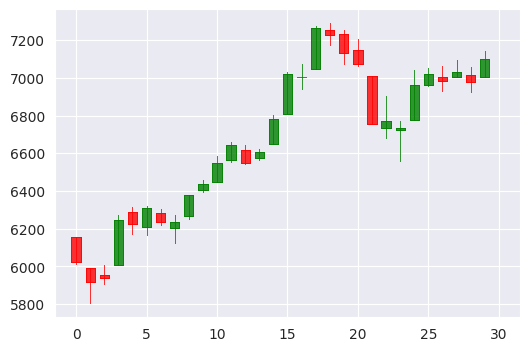

In [35]:
for idx in sp.index[3:9]:
    window = stoxx.iloc[idx:idx+30]
    fig, ax = plt.subplots(figsize=(6, 4))
    candlestick2_ohlc(ax, window.open, window.high,
                      window.low, window.close,
                      colorup='g', colordown='r', width=0.66, alpha=0.8)
    plt.show()

#### Iteración 3

 #### Se usará el modelo entrenado en la primera iteración. Para evitar usar ventanas que previamente hayan formado parte de un conjunto etiquetado se utilizarán los datos del EuroStoxx

In [36]:
window = 30
datos_etiquetados = pd.DataFrame(
    columns=["is_min_before_max", "dias_entre_minimos", "distancia_precio_minimos", "retorno",
             "distancia_primer_dia_minimo_local", "n_local_max", "diferencia_precio", "dias_entre_maximos",
             "distancia_primer_dia_maximo_local", "distancia_precio_maximos", "class"])

n_min = 4
n_max = 1

for data in db_dataset.iterrows():
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

    windata = ibex.loc[data[1].date:].head(window)

    is_min_before_max, dias_entre_minimos, distancia_precio_minimos, retorno, distancia_primer_dia_minimo_local, n_local_max, diferencia_precio, dias_entre_maximos, distancia_primer_dia_maximo_local, distancia_precio_maximos = etiquetado_datos(
        windata.copy())

    lows = windata.iloc[argrelextrema(windata.low.values, np.less_equal, order=n_min)[0]]["low"]
    lmax = windata.iloc[argrelextrema(windata.low.values, np.greater_equal, order=n_max)[0]]["low"]

    local_min = lows.to_frame().sort_values(by="low")[:2]
    local_max = lmax.to_frame().sort_values(by="low", ascending=False)[:2]
    local_max = lmax.to_frame()

    labeled_obs = {
        "is_min_before_max": is_min_before_max,
        "dias_entre_minimos": dias_entre_minimos,
        "distancia_precio_minimos": distancia_precio_minimos,
        "retorno": retorno,
        "distancia_primer_dia_minimo_local": distancia_primer_dia_minimo_local,
        "n_local_max": n_local_max,
        "diferencia_precio": diferencia_precio,
        "dias_entre_maximos": dias_entre_maximos,
        "distancia_primer_dia_maximo_local": distancia_primer_dia_maximo_local,
        "distancia_precio_maximos": distancia_precio_maximos,
        "class": data[1]["class"]
    }

    datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)

/tmp/ipykernel_1572444/2607020901.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_1572444/2607020901.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_1572444/2607020901.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_1572444/2607020901.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_

In [37]:
features = datos_etiquetados.loc[:, datos_etiquetados.columns != "class" ]
target = datos_etiquetados["class"]

In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

In [39]:

ft_norm_arr = MinMaxScaler().fit_transform(features)
ft_norm = pd.DataFrame(ft_norm_arr, columns=features.columns)

In [40]:
train_x, test_x, train_y, test_y = train_test_split(ft_norm.values,
                                                    target.values,
                                                    test_size=0.8,
                                                    stratify=target.values,
                                                    random_state=11
                                                    )

In [41]:
forest_it3 = RandomForestClassifier()

In [42]:
forest_it3.fit(train_x, train_y)
y_pred_single = forest_it3.predict(test_x)

In [ ]:
fper, tper, thresholds = roc_curve(test_y, y_pred_single)
plot_roc_curve(fper, tper)

In [45]:
# %matplotlib inline
window = 30
n = 1000000

etiquetas = np.zeros(n)
idfechas = np.zeros(n)
for i in range(n):
    idx = np.random.randint(0, ibex.shape[0] - window)
    idfechas[i] = idx
    random_window = ibex.iloc[idx:idx + window]

    datos_etiquetados = pd.DataFrame( columns=["is_min_before_max", "dias_entre_minimos", "distancia_precio_minimos", "retorno",
             "distancia_primer_dia_minimo_local", "n_local_max", "diferencia_precio", "dias_entre_maximos",
             "distancia_primer_dia_maximo_local", "distancia_precio_maximos"])

    is_min_before_max, dias_entre_minimos, distancia_precio_minimos, retorno, distancia_primer_dia_minimo_local, n_local_max, diferencia_precio, dias_entre_maximos, distancia_primer_dia_maximo_local, distancia_precio_maximos = etiquetado_datos(
    random_window.copy())

    if np.isnan(diferencia_precio):
        diferencia_precio = 0

    labeled_obs = {
        "is_min_before_max": is_min_before_max,
        "dias_entre_minimos": dias_entre_minimos,
        "distancia_precio_minimos": distancia_precio_minimos,
        "retorno": retorno,
        "distancia_primer_dia_minimo_local": distancia_primer_dia_minimo_local,
        "n_local_max": n_local_max,
        "diferencia_precio": diferencia_precio,
        "dias_entre_maximos": dias_entre_maximos,
        "distancia_primer_dia_maximo_local": distancia_primer_dia_maximo_local,
        "distancia_precio_maximos": distancia_precio_maximos,
    }

    datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
    ft_norm_arr = MinMaxScaler().fit_transform(datos_etiquetados)
    ft_norm = pd.DataFrame(ft_norm_arr, columns=datos_etiquetados.columns)
    predict_prob = forest_it3.predict_proba(ft_norm)

    predict_prob


    # if predict_prob[0][1] > 0.60:
    #
    #     fig, ax = plt.subplots(figsize=(6, 4))
    #     _ = candlestick2_ohlc(ax, windata.open, windata.high,
    #                           windata.low, windata.close,
    #                           colorup='g', colordown='r', width=0.66, alpha=0.8)
    #     plt.show()
    #     print(f'Ejemplo {i + 1} de {n}')
    #     print("Etiquete la siguiete grafica como:")
    #     print("[1] Doble suelo, [0] Sin doble suelo, [2] Descartar ejemplo")
    #     opcion_usuario = input()
    #
    #     if opcion_usuario == 'f':
    #         break
    #     elif opcion_usuario >= '0' and opcion_usuario <= '2':
    #         etiquetas[i] = opcion_usuario
    #     else:
    #         print('Error en la opción introducida. Ejemplo descartado')
    #         etiquetas[i] = 2
    # else:
    #     print(F"PROB IS {predict_prob[0][1]}")



/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]


/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/home/acp/Desktop/proyectos/virtualenvs/machine_learning/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_1572444/3684786344.py:35: FutureWarning: The 

[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]
[[0.62 0.38]]



KeyboardInterrupt

